# Test ray tracing

Goal of this notebook is to use Cosmogrid simulations to test the raytracing pipeline & Born pipeline, comparing it with theory

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import CMB_lensing_SBI
from CMB_lensing_SBI.healpy_utils import *
from CMB_lensing_SBI.PKDGRAV_utilities_scripts import *
from CMB_lensing_SBI.Raytracing import *
import CMB_lensing_SBI.Bornraytrace as Bornraytrace
import os
import healpy as hp
import astropy
import astropy.io.fits as fits
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM,wCDM
from astropy.cosmology import z_at_value
import frogress
import copy
import camb
from camb import model, initialpower
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as integrate
from scipy.interpolate import interp1d
import unyt
import yaml
from ekit import paths as path_tools
unyt.c.convert_to_units(unyt.km / unyt.s)

# short WL pipeline

In [ ]:
path_sims = '/global/cfs/cdirs/des/cosmogrid/raw/fiducial/cosmo_fiducial/' 

# setup cosmology ********************
with open(path_sims+'/run_{0}/params.yml'.format(0), "r") as f_in:
    config = yaml.safe_load(f_in.read())

config['nside'] = 512
cosmology = FlatLambdaCDM(H0= config['H0'] * u.km / u.s / u.Mpc, Om0=config['Om'])

    
k_tomo = dict()
cl_ = dict()
cl_old = dict()
cl_ray = dict()
    
# read n(z) ----------------------------
nz_file = '//global/cfs/cdirs//des/www/y3_chains/data_vectors/2pt_NG_final_2ptunblind_02_26_21_wnz_maglim_covupdate_6000HR.fits'     
mu = fits.open(nz_file)

redshift_distributions_sources = {'z':None,'bins':dict()}
redshift_distributions_sources['z'] = mu[6].data['Z_MID']
for ix in [1,2,3,4]:
    redshift_distributions_sources['bins'][ix] = mu[6].data['BIN{0}'.format(ix)]

    
    
count = 0
for RUN_i in range(100):
    count += 1
    # original path for particle counts
    shell = np.load(path_sims+'/run_{0}/shells_nside=512.npz'.format(RUN_i))   
    
    
    # read shells boundaries and comoving distances ----------------
    z_bounds     = dict()                                                                                         
    z_bounds['z-high'] = np.array([shell['shell_info'][i][3] for i in range(len(shell['shell_info']))])
    z_bounds['z-low'] = np.array([shell['shell_info'][i][2] for i in range(len(shell['shell_info']))])
    
    i_sprt = np.argsort(z_bounds['z-low'])
    z_bounds['z-low']= (z_bounds['z-low'])[i_sprt]
    z_bounds['z-high']= (z_bounds['z-high'])[i_sprt]

    z_bin_edges = np.hstack([z_bounds['z-low'],z_bounds['z-high'][-1]])
    comoving_edges = [cosmology.comoving_distance(x_) for x_ in np.array((z_bounds['z-low']))]
    
    z_centre = np.empty((len(comoving_edges)-1))
    for i in range(len(comoving_edges)-1):
        z_centre[i] = z_at_value(cosmology.comoving_distance,0.5*(comoving_edges[i]+comoving_edges[i+1]))

    un_ = comoving_edges[:(i+1)][0].unit
    comoving_edges = np.array([c.value for c in comoving_edges])
    comoving_edges = comoving_edges*un_
    
    
    overdensity_array = []
    for s_ in frogress.bar(range(len(z_bounds['z-high']))):
        shell_ = shell['shells'][i_sprt[s_]]
        shell_ =  (shell_-np.mean(shell_))/np.mean(shell_)
        #shell_ = hp.ud_grade(shell_, nside_out = config['nside'])
        overdensity_array.append(shell_)
    overdensity_array = np.array(overdensity_array)
    

    
    # TWO PIPELINES. old one with Born + new one with ray tracing
    # Born ray trace ----------------------
    kappa_lensing_old = np.copy(overdensity_array)*0.
    for i in frogress.bar(np.arange(1,kappa_lensing_old.shape[0])):
        kappa_lensing_old[i-1] = Bornraytrace.raytrace(cosmology.H0, cosmology.Om0,
                             overdensity_array=overdensity_array[:(i)].T,
                             a_centre=1./(1.+z_centre[:i]), 
                             comoving_edges=comoving_edges[:(i+1)],old_approach=True)


    # proper ray tracing
    raytrace_object = Raytracing(overdensity_array[:], cosmology, comoving_edges[:], config['nside'], NGP = False, volume_weighted = True)
    raytrace_object.raytrace_it()
    


    # compute cls old way
    nz_kernel_sample_dict = dict()
    for tomo_bin in [1,2,3,4]:
        k_tomo[tomo_bin] = np.zeros(hp.nside2npix(config['nside']))
        redshift_distributions_sources['bins'][tomo_bin][250:] = 0.
        nz_sample = Bornraytrace.recentre_nz(np.array(z_bin_edges).astype('float'),  redshift_distributions_sources['z'],  redshift_distributions_sources['bins'][tomo_bin] )
        nz_kernel_sample_dict[tomo_bin] = nz_sample*(z_bin_edges[1:]-z_bin_edges[:-1])
        for i in frogress.bar(range(len(comoving_edges)-2)):
            k_tomo[tomo_bin]  += kappa_lensing_old[i]*nz_kernel_sample_dict[tomo_bin][i]

    for tomo_bin in [1,2,3,4]:
        if RUN_i == 0:
            cl_[tomo_bin] = hp.anafast(k_tomo[tomo_bin])
        else:
            cl_[tomo_bin] += hp.anafast(k_tomo[tomo_bin])
            
            
    # compute WL cls (assuming no noise)

    for tomo_bin in [1,2,3,4]:
        k_tomo[tomo_bin] = np.zeros(hp.nside2npix(config['nside']))
        redshift_distributions_sources['bins'][tomo_bin][250:] = 0.
        nz_sample = np.interp(raytrace_object.redshifts,redshift_distributions_sources['z'], redshift_distributions_sources['bins'][tomo_bin])
        nz_sample = nz_sample/np.sum(nz_sample*((z_bin_edges[1:]-z_bin_edges[:-1])[:-1]))
        nz_kernel_sample_dict[tomo_bin] = nz_sample*((z_bin_edges[1:]-z_bin_edges[:-1])[:-1])
        for i in frogress.bar(range(len(comoving_edges)-2)):
            k_tomo[tomo_bin]  += raytrace_object.convergence_raytrace[i]*nz_kernel_sample_dict[tomo_bin][i+1]

    for tomo_bin in [1,2,3,4]:
        if RUN_i == 0:
            cl_ray[tomo_bin] = hp.anafast(k_tomo[tomo_bin])
        else:
            cl_ray[tomo_bin] += hp.anafast(k_tomo[tomo_bin])


        
for tomo_bin in [1,2,3,4]:
    cl_ray[tomo_bin] /= count
    cl_[tomo_bin] /= count
    


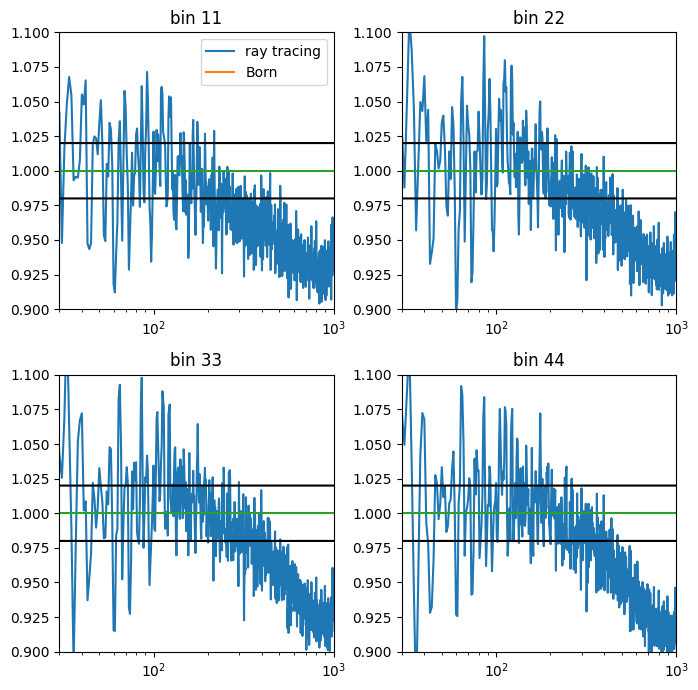

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,2, figsize=(7,7.))
from scipy.signal import savgol_filter

ddd = [1.,0.99,0.97,0.99]
ddd = [1.,1,1,1]
ix = 0
jx = 0

tomo_bin = 1
cl_pix = hp.sphtfunc.pixwin(config['nside'])
count = 0
for i in range(2):
    for j in range(2):
        base =   '/global/cfs/cdirs/des/mxlin/temp/testfiducial/shear_cl/bin_{0}_{0}.txt'.format(tomo_bin)
        base_l = '/global/cfs/cdirs/des/mxlin/temp/testfiducial/shear_cl/ell.txt'.format(tomo_bin)


        cl = np.loadtxt(base)
        ell = np.loadtxt(base_l)
        mask = ell< 30000
        f = interp1d(ell[mask],(cl*ell)[mask])

        # ******************************
        ll = np.arange(1,len(cl_ray[tomo_bin]))
        dx = savgol_filter(cl_ray[tomo_bin][:1000], 5, 3)
        theo = (f(ll))[:999]*cl_pix[1:1000]**2
        data = (dx[1:1000]*ll[:999])
        ax[i,j].plot(ll[:999],(data/theo),label = 'ray tracing')

        # ******************************
        ll = np.arange(1,len(cl_[tomo_bin]))
        dx = savgol_filter(cl_[tomo_bin][:1000], 5, 3)
        theo = (f(ll))[:999]*cl_pix[1:1000]**2
        data = (dx[1:1000]*ll[:999])
        ax[i,j].plot(ll[:999],(data/theo),label = 'Born')
        
        ax[i,j].plot(np.ones(len(ll)))
        ax[i,j].set_xscale('log')
        ax[i,j].set_xlim([30,1000])      
        ax[i,j].set_ylim([0.9,1.1])
        ax[i,j].plot(0.98*np.ones(len(ll)),color='black')
        ax[i,j].plot(1.02*np.ones(len(ll)),color='black')
        ax[i,j].set_title('bin {0}{0}'.format(tomo_bin,tomo_bin))
        tomo_bin +=1
        count +=1
        
ax[0,0].legend()
plt.tight_layout()
plt.show()